In [13]:
# AOC Stats Rainclouds N-back

In [14]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gaussian_kde

from stats_helpers import (
    iqr_outlier_filter,
    mixedlm_pairwise_contrasts,
    p_to_signif
)

from plotting_helpers import (
    add_stat_brackets,
    ensure_dir
)

In [14]:
# Setup

# I/O
input_csv  = "/Volumes/g_psyplafor_methlab$/Students/Arne/AOC/data/features/merged_data_nback.csv"
output_dir = "/Volumes/g_psyplafor_methlab$/Students/Arne/AOC/figures/stats/rainclouds"
ensure_dir(output_dir)

# Appearance (journal defaults)
pal = ["#93B8C4", "#82AD82", "#D998A2"]  # AOC pastels
mpl.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "savefig.transparent": False,
    "savefig.facecolor": "white",
    "savefig.bbox": "tight",
    "ps.fonttype": 42,
    "font.size": 15,
    "axes.titlesize": 15,
    "axes.labelsize": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "mathtext.default": "regular",
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "figure.edgecolor": "white",
    "axes.edgecolor": "white",
})

# Force set figure to white
sns.set_style("white")  # clean white background, no grey panel

# Inline “retina” only if running inside IPython/Jupyter (won’t crash as a script)
try:
    get_ipython().run_line_magic("config", "InlineBackend.figure_format = 'retina'")
except Exception:
    pass

# Canonical figure widths (inches)
COL = 3.35     # single column
ONEHALF = 5.0  # ~1.5 column
DOUBLE = 7.0   # double column
ASPECT = 0.72  # height = ASPECT * width (compact journal aspect)


In [15]:
# Load Data
dat = pd.read_csv(input_csv)

# Derivations / harmonisation
dat["GazeStd"] = (dat["GazeStdX"] + dat["GazeStdY"]) / 2.0

# Ensure Condition is ordered categorical “1/2/3-back”
cond_map = {1: "1-back", 2: "2-back", 3: "3-back"}
if np.issubdtype(dat["Condition"].dtype, np.number):
    dat["Condition"] = dat["Condition"].map(cond_map)
dat["Condition"] = pd.Categorical(
    dat["Condition"],
    categories=["1-back", "2-back", "3-back"],
    ordered=True
)

# Ensure ID is string/categorical for grouping
if dat["ID"].dtype != "O":
    dat["ID"] = dat["ID"].astype(str)

# Variables to plot
variables  = ["Accuracy", "ReactionTime"]
titles     = ["Accuracy", "Reaction Time"]
y_labels   = ["Accuracy [%]", "Reaction Time [s]"]
save_names = ["acc", "rt"]

# Outlier removal per condition & variable (1.5×IQR)
dat = iqr_outlier_filter(dat, variables, by="Condition")

# Pairwise comparisons in display order
comparisons = [("1-back", "2-back"), ("1-back", "3-back"), ("2-back", "3-back")]

/opt/anaconda3/envs/aoc-py311/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


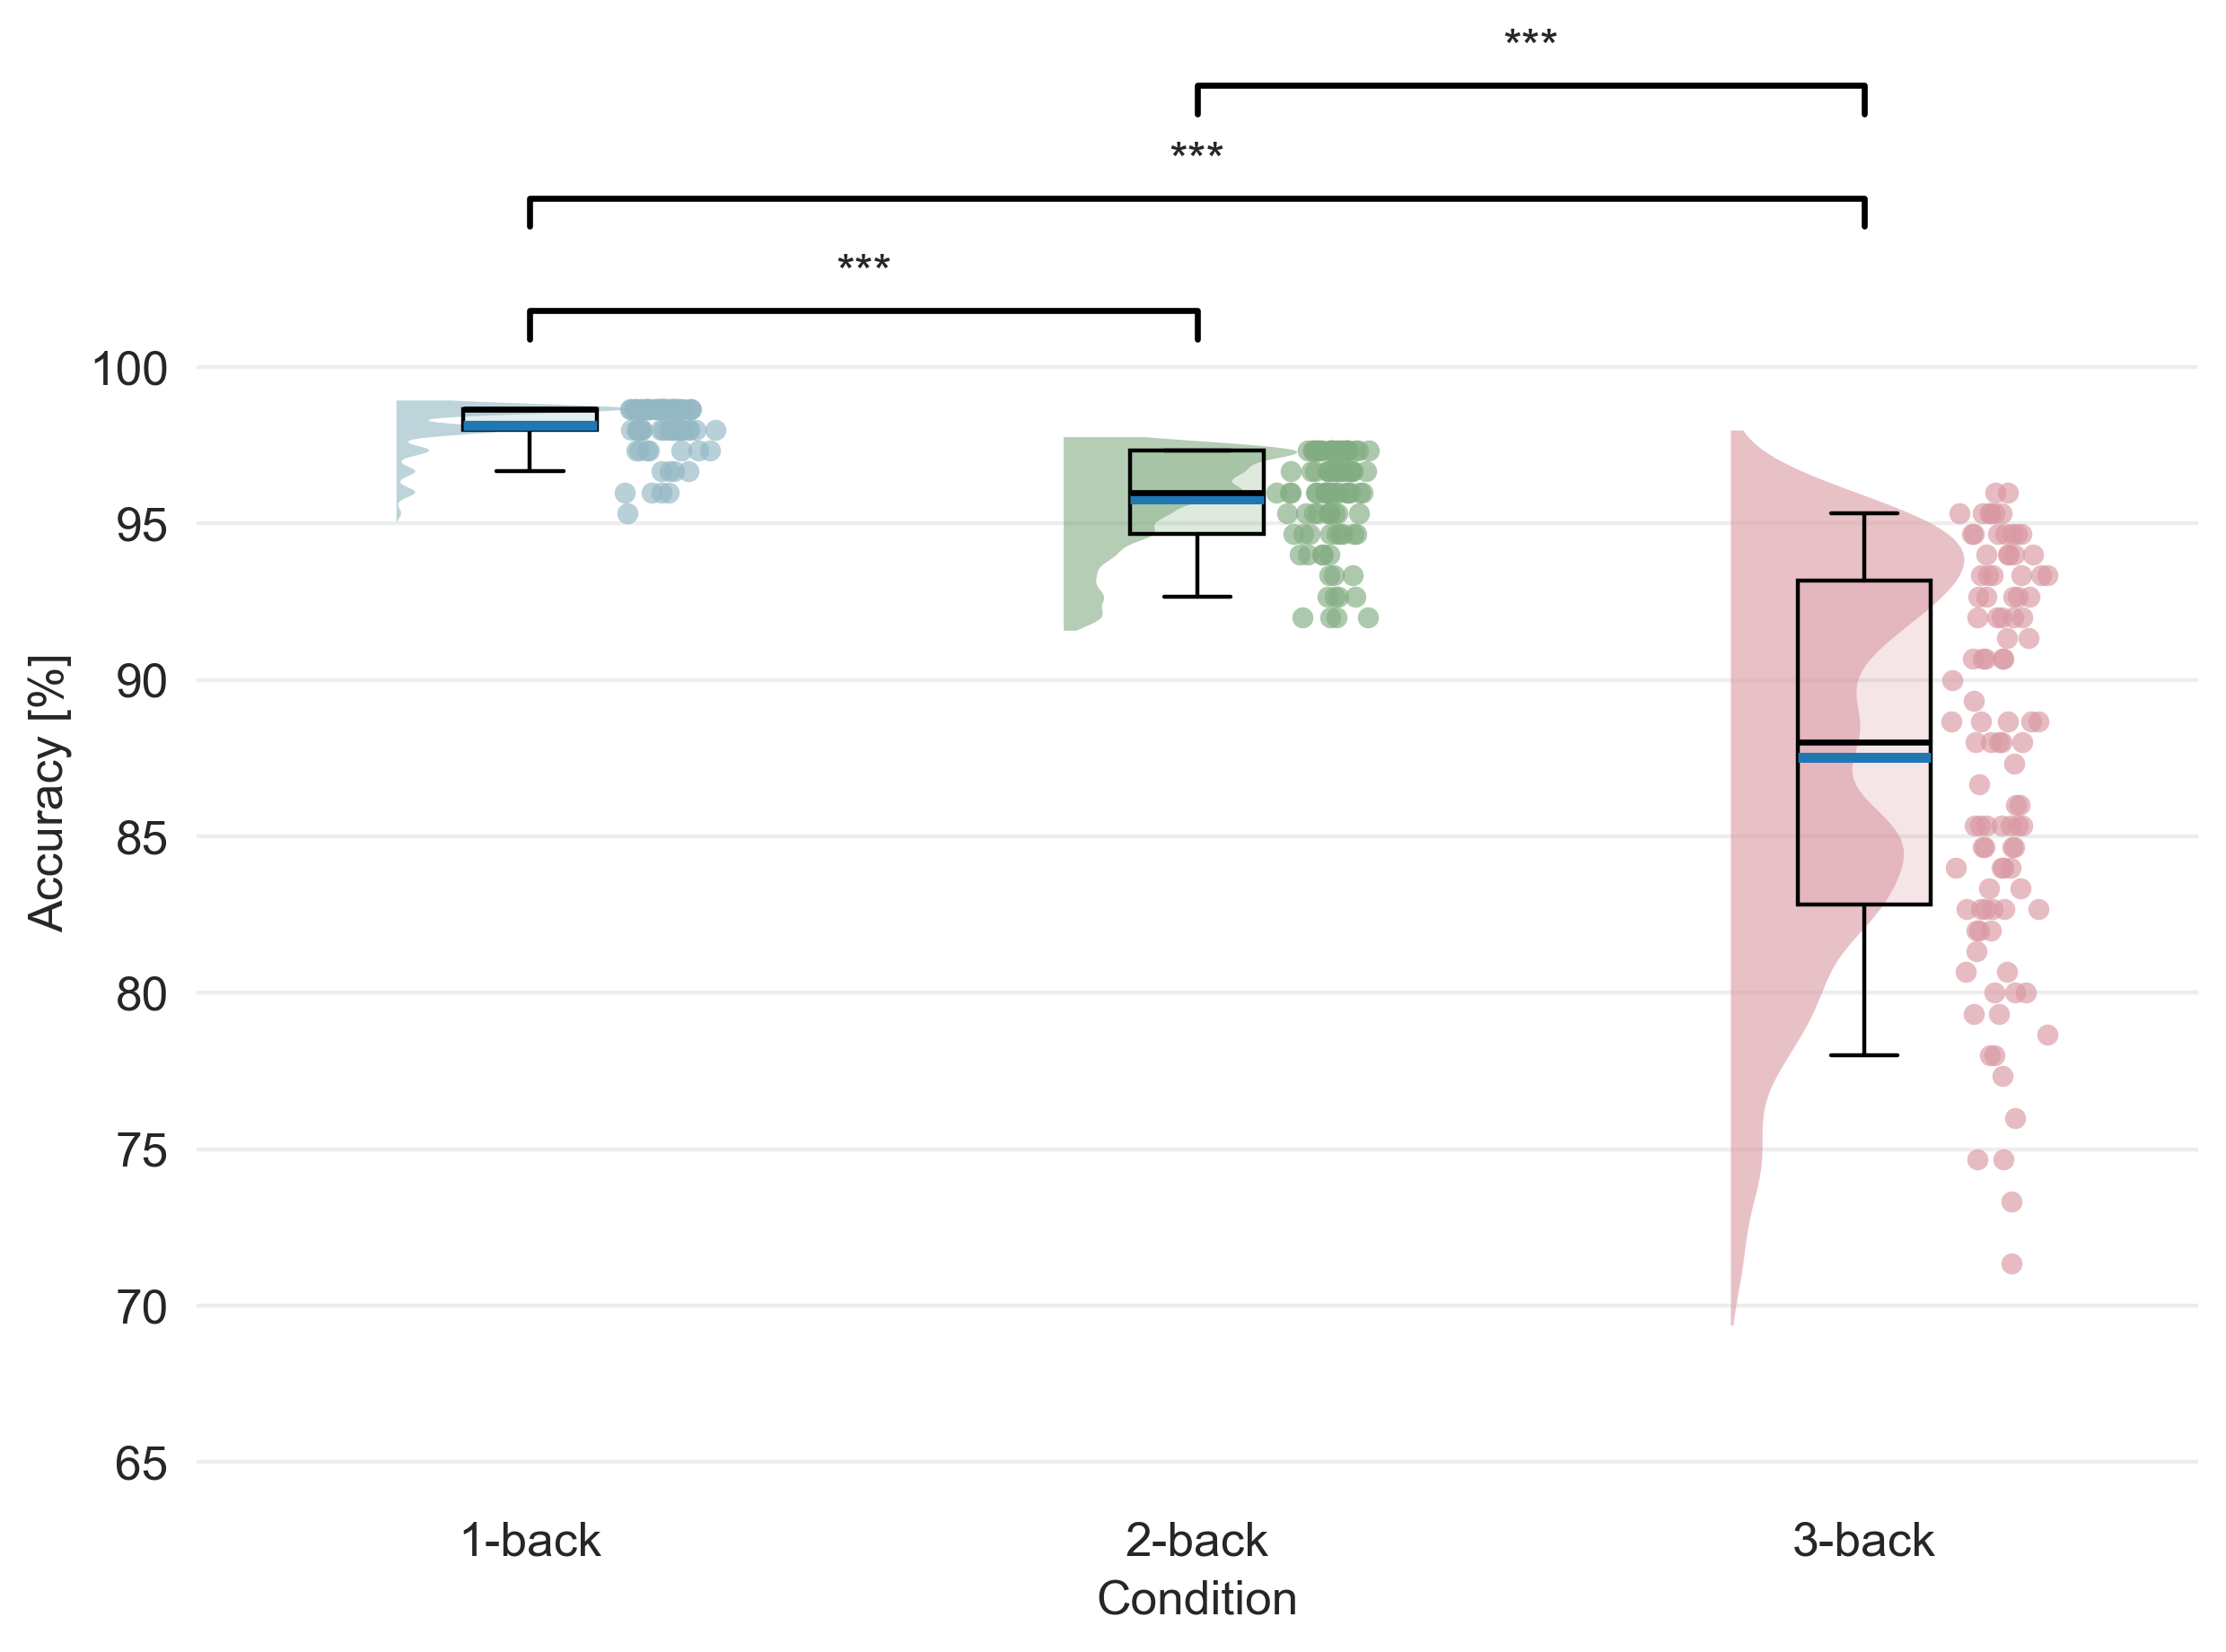

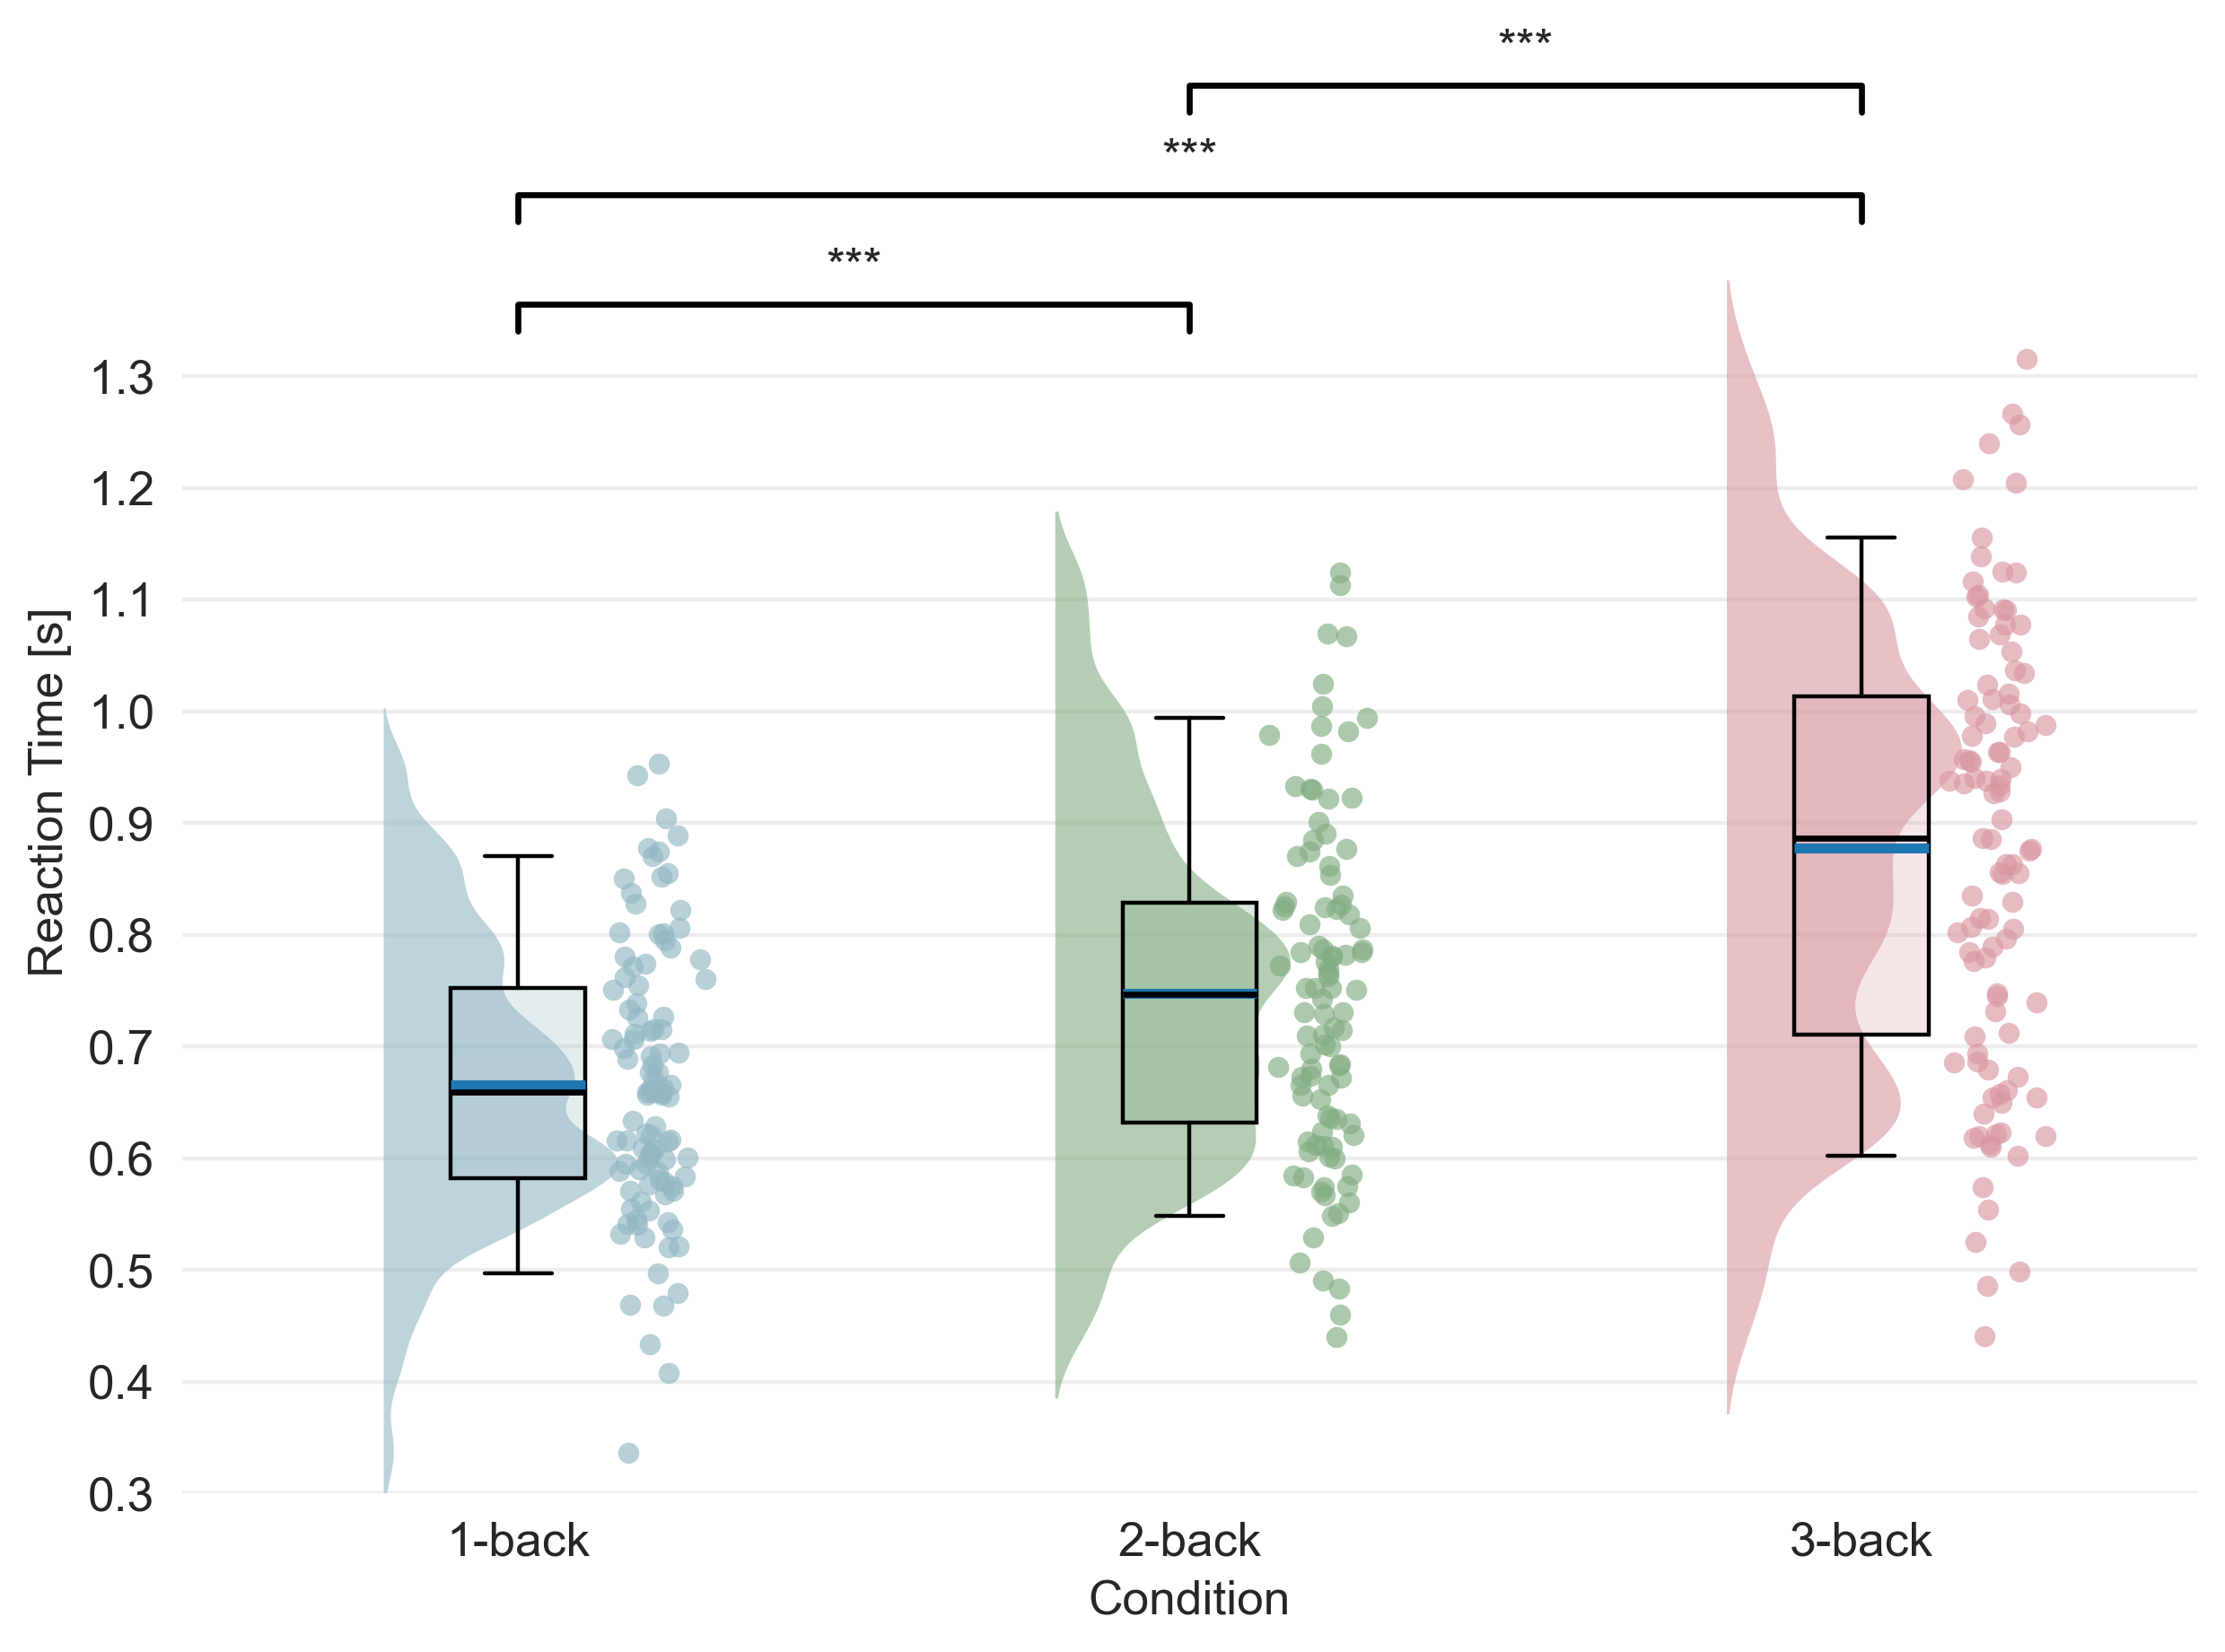

In [16]:
# Plotting

# Ensure category order once (place near your setup)
condition_order = list(dat["Condition"].dropna().unique())  # or fixed: ["1-back","2-back","3-back"]
pal_dict = dict(zip(condition_order, pal))

# Loop through variables
for var, ttl, ylab, sname in zip(variables, titles, y_labels, save_names):

    dvar = dat.loc[~dat[var].isna(), ["ID", "Condition", var]].copy()
    if dvar.empty:
        continue

    # enforce categorical order for plotting & stats
    dvar["Condition"] = pd.Categorical(dvar["Condition"], categories=condition_order, ordered=True)

    # y-limits (match R logic)
    if var == "Accuracy":
        lower_bound = 64
        nominal_upper = 100
    elif var == "GazeDeviation":
        lower_bound = 5
        nominal_upper = None
    else:
        vmin = dvar[var].min()
        vmax = dvar[var].max()
        if np.isfinite(vmin):
            lower_bound = vmin
        else:
            lower_bound = None
        if np.isfinite(vmax):
            nominal_upper = vmax
        else:
            nominal_upper = None

    # --------------------------------------
    # Mixed model + pairwise contrasts (Bonf)
    # --------------------------------------
    pw = mixedlm_pairwise_contrasts(
        dvar.rename(columns={var: "value"}),
        value_col="value",
        group_col="Condition",
        id_col="ID",
        p_adjust="bonferroni"
    )

    # --------------------------------
    # Stats plot with brackets
    # --------------------------------
    fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")
    fig.patch.set_alpha(1.0)
    ax.patch.set_alpha(1.0)
    ax.set_facecolor("white")

    # -----------------------------
    # Manual "raincloud" construction
    # -----------------------------
    # Tunable aesthetics
    viol_alpha   = 0.60     # violin fill opacity
    dot_alpha    = 0.65     # raindrop opacity
    dot_size     = 28.0     # raindrop size (points^2)
    box_width    = 0.20     # boxplot width
    cloud_offset = -0.20    # shift of violin relative to category centre
    dot_offset   = +0.20    # shift of dots relative to category centre
    max_violsw   = 0.35     # maximum half-violin horizontal extent
    bw_method    = 0.20     # roughly matches ptitprince bw=.2

    # x coordinates per condition in the specified order
    xpos = {c: i for i, c in enumerate(condition_order)}

    # jitter helper (deterministic per figure for reproducibility)
    rng = np.random.default_rng(12345)

    # normalise density widths within each group for a comparable look
    # (scale each group’s max density to max_violsw)
    for cond in condition_order:
        yvals = dvar.loc[dvar["Condition"] == cond, var].dropna().to_numpy()
        if yvals.size == 0:
            continue

        # KDE-based half-violin; fall back to a tiny blob if KDE fails
        try:
            kde = gaussian_kde(yvals, bw_method=bw_method)
            y_min = np.nanmin(yvals)
            y_max = np.nanmax(yvals)
            # Ensure at least some span to avoid degenerate fills
            if not np.isfinite(y_min) or not np.isfinite(y_max) or y_min == y_max:
                y_grid = np.linspace(y_min - 1e-6, y_max + 1e-6, 50)
            else:
                pad = 0.08 * (y_max - y_min) if (y_max - y_min) > 0 else 1.0
                y_grid = np.linspace(y_min - pad, y_max + pad, 200)

            dens = kde(y_grid)
            # scale to a fixed max width
            if np.nanmax(dens) > 0:
                scale = max_violsw / np.nanmax(dens)
            else:
                scale = 0.0
            x_right = xpos[cond] + cloud_offset + dens * scale  # half-violin to the right
            x_left  = np.full_like(y_grid, xpos[cond] + cloud_offset)

            # build polygon (left spine up, right spine down)
            poly_x = np.concatenate([x_left, x_right[::-1]])
            poly_y = np.concatenate([y_grid, y_grid[::-1]])
            ax.fill(poly_x, poly_y, facecolor=pal_dict[cond], edgecolor="none", alpha=viol_alpha)

        except Exception:
            # tiny fallback blob at the mean
            ax.scatter([xpos[cond] + cloud_offset], [np.nanmean(yvals)], s=60,
                       facecolor=pal_dict[cond], edgecolor="none", alpha=viol_alpha)

        # raindrops (jittered scatter) – keep them on the opposite side for separation
        x_jit = xpos[cond] + dot_offset + rng.normal(0, 0.03, size=yvals.size)
        ax.scatter(x_jit, yvals, s=dot_size, alpha=dot_alpha, color=pal_dict[cond], linewidths=0, zorder=3)

        # narrow boxplot centred on the category tick (no fliers; thin line; light face)
        bp = ax.boxplot(
            [yvals],
            positions=[xpos[cond]],
            widths=box_width,
            vert=True,
            patch_artist=True,
            showfliers=False,
            whis=(5, 95),         # similar to a trimmed look; change if you prefer default IQR whiskers
            medianprops=dict(color="black", linewidth=1.5),
            boxprops=dict(linewidth=1.0),
            whiskerprops=dict(linewidth=1.0),
            capprops=dict(linewidth=1.0)
        )
        # colour the box with slightly transparent face matching the palette
        for patch in bp["boxes"]:
            patch.set_facecolor(mpl.colors.to_rgba(pal_dict[cond], 0.25))
            patch.set_edgecolor("black")

    # minimalist overlay of the mean as an underscore, no connecting lines
    group_means = (
        dvar.groupby("Condition", observed=True)[var]
            .mean()
            .reindex(condition_order)
            .to_numpy()
    )
    # draw a short underscore at each category centre
    underscore_halfwidth = 0.10
    for i, m in enumerate(group_means):
        if np.isfinite(m):
            ax.hlines(m, i - underscore_halfwidth, i + underscore_halfwidth, linewidth=2.5)

    # Remove duplicate legend produced by hue==x
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

    # No box: remove all spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Thin horizontal y-grid at tick positions; no vertical grid
    ax.yaxis.grid(True, linewidth=1, alpha=0.35)
    ax.xaxis.grid(False)

    # Remove lines around density (violins) and make fills slightly transparent
    for coll in ax.collections:
        # Violins are PolyCollections; remove edge and lighten alpha
        if isinstance(coll, mpl.collections.PolyCollection):
            try:
                coll.set_edgecolor("none")
                coll.set_linewidth(0.0)
                fc = coll.get_facecolors()
                if fc is not None and len(fc):
                    fc[:, 3] = np.minimum(fc[:, 3], 0.6)  # ~60% opacity
                    coll.set_facecolors(fc)
            except Exception:
                pass
        # Raindrop dots are PathCollections; enlarge and add slight transparency
        if isinstance(coll, mpl.collections.PathCollection):
            try:
                s = coll.get_sizes()
                if s is not None and len(s):
                    # increase sizes uniformly (tweak as desired)
                    coll.set_sizes(np.full_like(s, 28.0, dtype=float))
                coll.set_alpha(0.65)
            except Exception:
                pass

    # Labels and title
    ax.set_xlabel("Condition")
    ax.set_ylabel(ylab)
    ax.set_title("")
    ax.set_xticks(range(len(condition_order)))
    ax.set_xticklabels(condition_order)

    # y-scaling for brackets
    ymin = lower_bound
    ymax_data = dvar[var].max()
    ymax_cap  = nominal_upper if nominal_upper is not None else ymax_data
    ymax      = max(ymax_data, ymax_cap)
    rng       = ymax - ymin
    step      = 0.10 * rng if rng > 0 else 1.0
    head      = 0.02 * rng if rng > 0 else 0.2

    xcats = list(dvar["Condition"].cat.categories)

    y_positions = []
    start = ymax + 0.025 * rng
    for i in range(len(comparisons)):
        y_positions.append(start + i * step)

    if len(y_positions):
        ax.set_ylim(ymin, y_positions[-1] + head)
    else:
        ax.set_ylim(ymin, ymax)

    # Significance labels from pairwise table
    labels = []
    for (g1, g2) in comparisons:
        row = pw.loc[(pw["group1"] == g1) & (pw["group2"] == g2)]
        labels.append("n.s." if row.empty else p_to_signif(float(row["p_adj"].iloc[0])))

    # 3) Call brackets with the explicit mapping
    add_stat_brackets(
        ax=ax,
        xcats=condition_order,              # or xcats
        comparisons=comparisons,
        y_positions=y_positions,
        labels=labels,
        xmap=xpos
    )

    # Axis-specific ticks (as you had)
    if var == "Accuracy":
        ax.set_yticks(np.arange(65, 101, 5))
    elif var == "ReactionTime":
        ax.set_yticks(np.round(np.arange(0.3, 1.31, 0.1), 2))

    fig.tight_layout()
    fig.savefig(
        os.path.join(output_dir, f"AOC_stats_rainclouds_{sname}_nback_stats.png"),
        dpi=300,
        transparent=False,               # CRITICAL
        facecolor=fig.get_facecolor(),   # keep white
        edgecolor=fig.get_edgecolor() if hasattr(fig, "get_edgecolor") else "white"
    )